In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [21]:
train_1 = pd.read_csv('data/scenario_1/train.csv')
test_1 = pd.read_csv('data/scenario_1/test.csv')
train_2 = pd.read_csv('data/scenario_2/train.csv')
test_2 = pd.read_csv('data/scenario_2/test.csv')
train_3 = pd.read_csv('data/scenario_3/train.csv')
test_3 = pd.read_csv('data/scenario_3/test.csv')

trains = [train_1['price'],train_2['price'],train_3['price']]
tests = [test_1['price'],test_2['price'],test_3['price']]

In [22]:
def build_model(train_data):
      # Initial approximation of parameters
    Ps = [7,8,9]
    Qs = [7,9]
    d=[1]
    parameters = product(Ps,d,Qs)
    parameters_list = list(parameters)

    # Model Selection
    results = []
    for param in parameters_list:
        try:
            model = ARIMA(train_data, order=(param[0], param[1], param[2])).fit()
        except ValueError:
            print(parameters_list)
            continue
        results.append([model,param])
    return results    

In [23]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

def mape_model(test,model):
         pred = model.forecast(steps=len(test))
         return mean_absolute_percentage_error(test,pred)

In [24]:
scen_models_res = []

# build model of all scenarios
for train in trains:
    models_res = build_model(train)
    scen_models_res.append(models_res)

In [25]:
evaluate_table = pd.DataFrame(columns=['Model','Scenario','MAPE'])
# calculate MAPE of all possible models * screnarios
for scen in range(0,3):
     test_scen = tests[scen]
     for par_num in range(0,6):
      model_scen = scen_models_res[scen][par_num][0]
      mape = mape_model(test_scen,model_scen)
      params_model = scen_models_res[scen][par_num][1]
      evaluate_table.loc[len(evaluate_table)] = [params_model,scen,mape]
     
evaluate_table = evaluate_table.pivot(index='Model',values='MAPE',columns='Scenario')

evaluate_table.index.name = None

evaluate_table.columns = ['Scenario 1','Scenario 2','Scenario 3']

# print(evaluate_table.to_csv('./result/evaluate-models.csv'))

evaluate_table

,Scenario 1,Scenario 2,Scenario 3
"(7, 1, 7)",2.484014,3.221262,0.841848
"(7, 1, 9)",2.166798,3.221364,0.406080
"(8, 1, 7)",2.762035,3.246296,0.423542
"(8, 1, 9)",2.409949,3.226004,0.548837
"(9, 1, 7)",2.235927,3.224270,0.332102
"(9, 1, 9)",2.424587,3.184966,0.519813


In [26]:
best_model = scen_models_res[2][1][0]

In [32]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 2937
Model:                 ARIMA(7, 1, 9)   Log Likelihood              -23769.707
Date:                Sat, 10 Dec 2022   AIC                          47573.414
Time:                        20:19:49   BIC                          47675.156
Sample:                             0   HQIC                         47610.051
                               - 2937                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0407      0.075      0.541      0.589      -0.107       0.188
ar.L2          0.2215      0.065      3.410      0.001       0.094       0.349
ar.L3         -0.4552      0.052     -8.713      0.000      -0.558      -0.353
ar.L4          0.3712      0.070      5.310      0.000       0.234       0.508
ar.L5         -0.2123      0.052     -4.112      0.000      -0.314      -0.111
ar.L6         -0.3858      0.051     -7.504      0.000      -0.487      -0.285
ar.L7          0.5948      0.063      9.414      0.000       0.471       0.719
ma.L1         -0.0543      0.076     -0.717      0.474      -0.203       0.094
ma.L2         -0.2147      0.065     -3.290      0.001      -0.343      -0.087
ma.L3          0.4827      0.052      9.338      0.000       0.381       0.584
ma.L4         -0.3591      0.070     -5.135      0.000      -0.496      -0.222
ma.L5          0.2305      0.053      4.379      0.000       0.127       0.334
ma.L6          0.4055      0.055      7.377      0.000       0.298       0.513
ma.L7         -0.6434      0.065     -9.933      0.000      -0.770      -0.516
ma.L8         -0.0264      0.011     -2.336      0.019      -0.049      -0.004
ma.L9          0.0954      0.013      7.498      0.000       0.070       0.120
sigma2      6.435e+05   6271.781    102.605      0.000    6.31e+05    6.56e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             27600.51
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):            1077.13   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

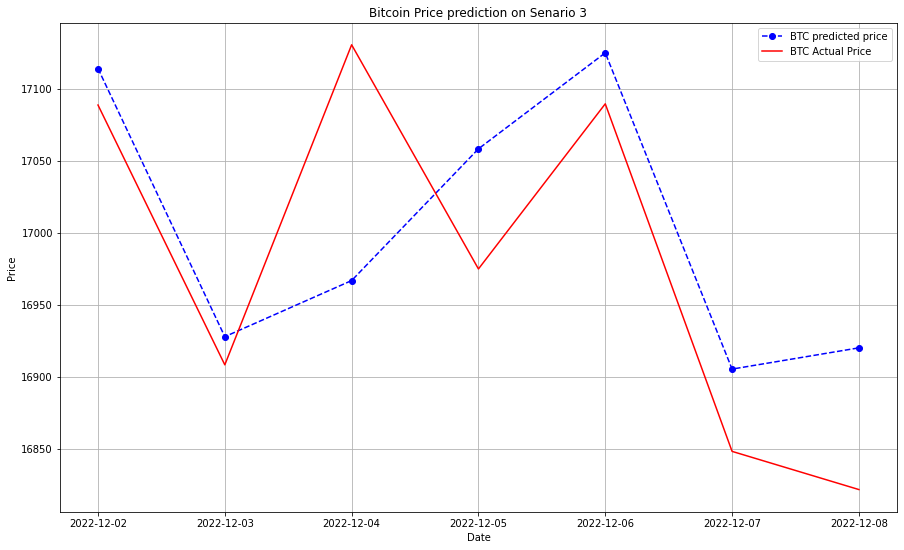

In [28]:
plt.figure(figsize=(15,9))
plt.grid(True)

timeline_forecast = test_3['Date']
actual_price = test_3['price']

plt.plot(timeline_forecast, best_model.forecast(steps=len(timeline_forecast)), color='blue', marker='o', linestyle='dashed',label='BTC predicted price')
plt.plot(timeline_forecast, actual_price, color ='red', label='BTC Actual Price')

plt.title('Bitcoin Price prediction on Senario 3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()


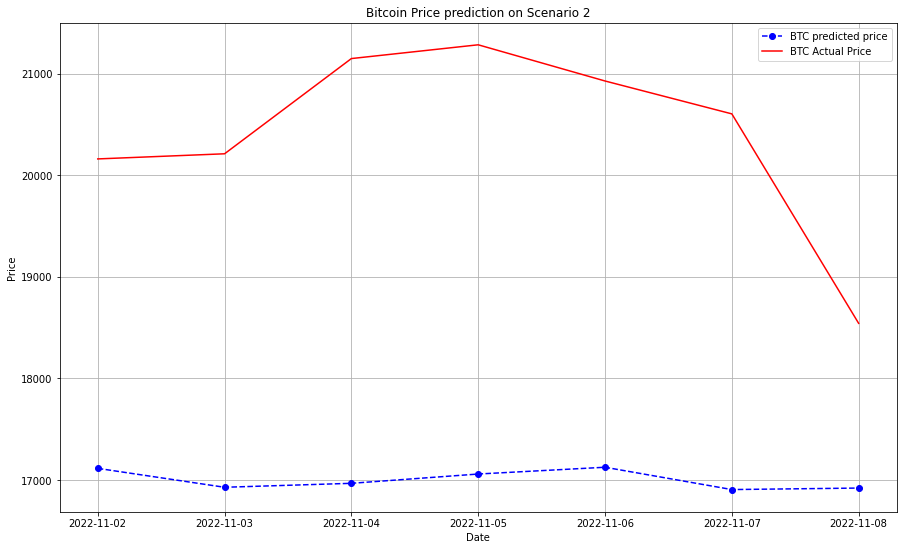

In [29]:
plt.figure(figsize=(15,9))
plt.grid(True)

timeline_forecast = test_2['Date']
actual_price = test_2['price']

plt.plot(timeline_forecast, best_model.forecast(steps=len(timeline_forecast)), color='blue', marker='o', linestyle='dashed',label='BTC predicted price')
plt.plot(timeline_forecast, actual_price, color ='red', label='BTC Actual Price')

plt.title('Bitcoin Price prediction on Scenario 2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

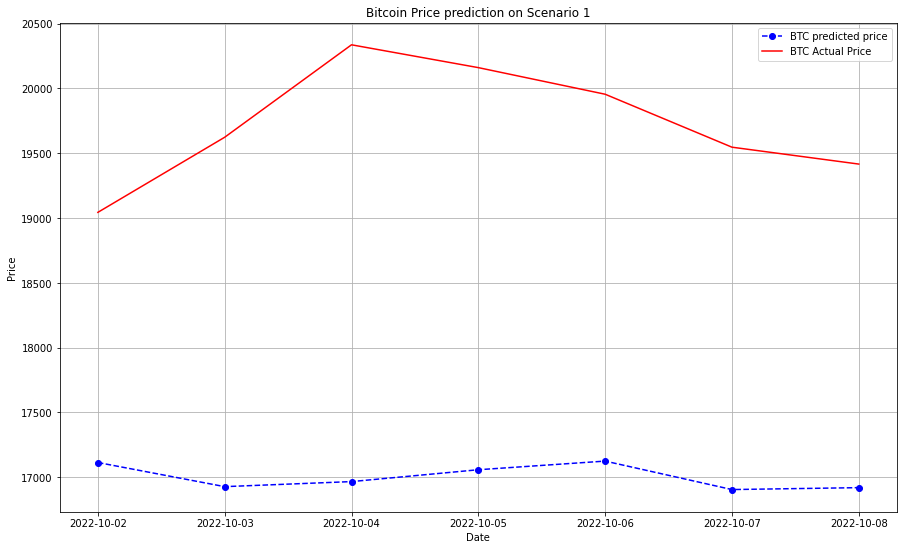

In [30]:
plt.figure(figsize=(15,9))
plt.grid(True)

timeline_forecast = test_1['Date']
actual_price = test_1['price']

plt.plot(timeline_forecast, best_model.forecast(steps=len(timeline_forecast)), color='blue', marker='o', linestyle='dashed',label='BTC predicted price')
plt.plot(timeline_forecast, actual_price, color ='red', label='BTC Actual Price')

plt.title('Bitcoin Price prediction on Scenario 1')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()